In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 1 — Introduction to Machine Learning  
## Lesson 7: Common Misconceptions and Challenges in ML

### Learning objectives
By the end of this lesson, you should be able to:

1. Separate *misconceptions* (wrong mental models) from *challenges* (real constraints).
2. Explain why seemingly “great” offline metrics frequently fail in production.
3. Detect data leakage using concrete tests and red-flag heuristics.
4. Choose evaluation splits and metrics that match the real deployment setting.
5. Implement reproducible experiments (seeds, baselines, CV) and communicate uncertainty.

### Why this lesson matters
Machine learning is often presented as a linear recipe: load data → train model → deploy.  
In practice, the majority of time is spent on **validating assumptions**:

- Is the label meaningful and stable?
- Is the data representative of the decision you will actually make?
- Is the evaluation protocol aligned with the production environment?
- Are you optimizing the right metric for the right cost?

This lesson is intentionally “practice-driven”: we will run short experiments on several datasets to illustrate failure modes and their mitigations.



## 1) Misconceptions vs. challenges (a taxonomy)

### Misconceptions (mental-model failures)
Common examples:

- **“Accuracy is enough.”** Ignores class imbalance, asymmetric costs, calibration, and decision thresholds.
- **“More data fixes everything.”** Confuses quantity with label quality and representativeness.
- **“A complex model is always better.”** Underestimates overfitting and operational fragility.
- **“Feature importance proves causality.”** Confuses predictive association with causal effect.
- **“Train/test split is a formality.”** Underestimates time, groups, duplicates, and leakage.

### Challenges (reality constraints)
Common examples:

- **Label noise and ambiguity**: human labels disagree; business definitions evolve.
- **Non-stationarity**: user behavior and policies drift over time.
- **Sparse signals**: rare events; missing or delayed outcomes.
- **Operational constraints**: latency, interpretability requirements, governance, privacy.

A project fails when misconceptions cause you to “skip” work needed to address challenges.

---

## 2) Where failure happens: a risk-first view

Instead of focusing on the algorithm, focus on risk:

- **Measurement risk**: the label does not match what you care about.
- **Selection risk**: training data is not representative of deployment.
- **Evaluation risk**: your validation protocol overestimates true performance.
- **Operational risk**: the model cannot be reliably served or monitored.

A useful discipline is to articulate:

- What decision will the model support?
- What is the cost of false positives vs false negatives?
- What data is available at decision time (and what is not)?



## 3) The “offline vs online” gap

Offline metrics are computed on historical data under your chosen split.  
Production performance depends on:

- What population arrives tomorrow (not what arrived last year).
- What features are available at prediction time.
- How humans respond to model outputs (feedback loops).
- Whether the target is delayed or censored.

This is why you should treat offline evaluation as an **estimate** with uncertainty, not as a guarantee.

### A small but important formula
For a metric $M$ measured on a test set, you should think in terms of:

$$
M_{\text{prod}} \approx M_{\text{test}} - \Delta_{\text{shift}} - \Delta_{\text{leakage}} - \Delta_{\text{feedback}}
$$

where each $\Delta$ term is nonnegative “degradation” caused by mismatch to production.  
The goal is to make these deltas as small as possible by good experimental design.

---

## 4) Setup

We will now run small experiments. Every experiment follows this discipline:

1. **Define the question** (what misconception/challenge are we demonstrating?).
2. **Choose a baseline** (dummy model or trivial rule).
3. **Train a simple model** (often logistic/linear regression).
4. **Inspect metrics + error structure** (confusion matrix, distribution of errors).
5. **State the mitigation** (what you should do in real projects).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_auc_score, average_precision_score,
                             r2_score)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("numpy:", np.__version__)
print("pandas:", pd.__version__)

numpy: 2.1.2
pandas: 2.2.3


In [3]:
from pathlib import Path

def load_csv(rel_path: str) -> pd.DataFrame:
    p = Path(rel_path)
    if not p.exists():
        raise FileNotFoundError(f"Expected file not found: {p.resolve()}")
    return pd.read_csv(p, low_memory=False)

print("Working directory:", Path.cwd())
print("Example dataset exists:", Path("../../../Datasets/Classification/diabetes.csv").exists())

Working directory: C:\Users\LENOVO.PIESC\Desktop\Machine_Learning_Tutorials\Tutorials\English\Chapter1
Example dataset exists: True



## 5) Misconception: “High accuracy means the model is good” (class imbalance + thresholds)

Accuracy answers: “What fraction of predictions are correct?”  
But decision-making usually cares about *which* errors occur.

If positives are rare, predicting “negative” always can yield high accuracy.

### What to look at instead
- Confusion matrix
- Precision/recall/F1
- PR-AUC (Average Precision) for imbalanced problems
- Threshold sweeps to reflect cost tradeoffs

We will demonstrate this by intentionally increasing imbalance in the diabetes dataset.


In [4]:
# Load diabetes dataset
df = load_csv("../../../Datasets/Classification/diabetes.csv")
print("diabetes shape:", df.shape)
print(df.head(5).to_string(index=False))

# Create a more imbalanced dataset: keep all Non-Diabetic, downsample Diabetic
df_pos = df[df["classification"] == "Diabetic"]
df_neg = df[df["classification"] == "Non-Diabetic"]

df_pos_small = df_pos.sample(frac=0.12, random_state=RANDOM_STATE)
df_imb = pd.concat([df_neg, df_pos_small], axis=0).sample(frac=1.0, random_state=RANDOM_STATE)

print("\nClass distribution (imbalanced):")
print(df_imb["classification"].value_counts())

X = df_imb.drop(columns=["classification"])
y = (df_imb["classification"] == "Diabetic").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# Baseline: always predict majority class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Logistic regression baseline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

def summarize_binary(y_true, y_hat, y_score=None, name="model"):
    acc = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    print(f"\n{name}: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")
    print("confusion matrix:\n", confusion_matrix(y_true, y_hat))
    if y_score is not None:
        try:
            auc = roc_auc_score(y_true, y_score)
            ap = average_precision_score(y_true, y_score)
            print(f"ROC-AUC={auc:.3f}, PR-AUC(AP)={ap:.3f}")
        except Exception as e:
            print("AUC computation issue:", e)

summarize_binary(y_test, y_pred_dummy, name="Dummy (most frequent)")
summarize_binary(y_test, y_pred, y_score=y_proba, name="Logistic Regression")

print("\nClassification report (LogReg):")
print(classification_report(y_test, y_pred, target_names=["Non-Diabetic", "Diabetic"], zero_division=0))

diabetes shape: (768, 9)
 Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DiabetesPedigreeFunction  Age classification
           6      148             72             35        0 33.6                     0.627   50       Diabetic
           1       85             66             29        0 26.6                     0.351   31   Non-Diabetic
           8      183             64              0        0 23.3                     0.672   32       Diabetic
           1       89             66             23       94 28.1                     0.167   21   Non-Diabetic
           0      137             40             35      168 43.1                     2.288   33       Diabetic

Class distribution (imbalanced):
classification
Non-Diabetic    500
Diabetic         32
Name: count, dtype: int64

Dummy (most frequent): accuracy=0.940, precision=0.000, recall=0.000, f1=0.000
confusion matrix:
 [[125   0]
 [  8   0]]

Logistic Regression: accuracy=0.940, precision=0.000, recall=0.00

In [5]:
# Threshold sweep: choosing a threshold is a cost decision
thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    y_hat = (y_proba >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_hat, average="binary", zero_division=0)
    rows.append((t, prec, rec, f1))
tbl = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "f1"])

print(tbl.head(10).to_string(index=False))
best_f1 = tbl.iloc[tbl["f1"].idxmax()]
print("\nBest F1 threshold:")
print(best_f1.to_string())

 threshold  precision  recall       f1
      0.05   0.152174   0.875 0.259259
      0.10   0.100000   0.250 0.142857
      0.15   0.200000   0.250 0.222222
      0.20   0.333333   0.125 0.181818
      0.25   0.500000   0.125 0.200000
      0.30   0.000000   0.000 0.000000
      0.35   0.000000   0.000 0.000000
      0.40   0.000000   0.000 0.000000
      0.45   0.000000   0.000 0.000000
      0.50   0.000000   0.000 0.000000

Best F1 threshold:
threshold    0.050000
precision    0.152174
recall       0.875000
f1           0.259259



## 6) Misconception: “If it fits training well, it will generalize” (overfitting)

Overfitting is not a moral failure; it is a capacity–data mismatch.

- When the hypothesis class is too flexible, you can fit noise.
- In real projects, noise is unavoidable: measurement error, label noise, and unobserved confounders.

A practical sign is when performance improves on train but stagnates or degrades on test as capacity increases.

We will do a controlled capacity increase using polynomial features on the iris dataset.


iris shape: (150, 5)
 sepal_length  sepal_width  petal_length  petal_width classification
          5.4          3.7           1.5          0.2    Iris-setosa
          4.8          3.4           1.6          0.2    Iris-setosa
          4.8          3.0           1.4          0.1    Iris-setosa
          4.3          3.0           1.1          0.1    Iris-setosa
          5.8          4.0           1.2          0.2    Iris-setosa
 degree  train_accuracy  test_accuracy
      1        0.980952       0.911111
      2        0.980952       0.911111
      3        0.990476       0.911111
      4        0.990476       0.933333
      5        1.000000       0.933333
      6        1.000000       0.911111


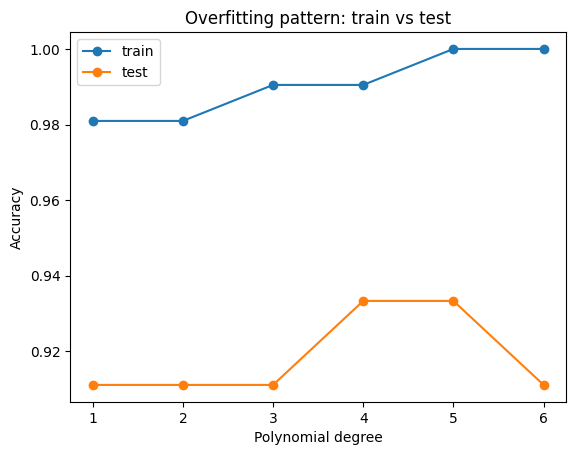

In [6]:
# Overfitting demo on iris: increasing polynomial degree increases capacity
iris = load_csv("../../../Datasets/Classification/iris.csv")
print("iris shape:", iris.shape)
print(iris.head(5).to_string(index=False))

X = iris.drop(columns=["classification"])
y = iris["classification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

degrees = [1, 2, 3, 4, 5, 6]
results = []
for d in degrees:
    clf = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ])
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    results.append((d, train_acc, test_acc))

res = pd.DataFrame(results, columns=["degree", "train_accuracy", "test_accuracy"])
print(res.to_string(index=False))

plt.figure()
plt.plot(res["degree"], res["train_accuracy"], marker="o", label="train")
plt.plot(res["degree"], res["test_accuracy"], marker="o", label="test")
plt.xlabel("Polynomial degree")
plt.ylabel("Accuracy")
plt.title("Overfitting pattern: train vs test")
plt.legend()


## 7) Challenge: Data leakage (silent failure)

Leakage is “silent” because it often produces *beautiful* validation results.

### A leak is any feature you cannot compute at prediction time
Examples:
- Using “days since last payment” when last payment is recorded after the decision.
- Aggregations computed across all users including the test users.
- Target encoding without proper fold discipline.
- Features that are proxies for labeling process rather than phenomenon.

We will intentionally create a leaky feature in a house price regression example and show how it inflates $R^2$.


In [7]:
# Leakage demo on house prices
hp = load_csv("../../../Datasets/Regression/house-prices.csv")
print("house-prices shape:", hp.shape)
print(hp.head(5).to_string(index=False))

y = hp["Price"].values
X = hp.drop(columns=["Price"])

# Add a leaky feature: almost the target (this simulates post-outcome information)
rng = np.random.default_rng(RANDOM_STATE)
X_leaky = X.copy()
X_leaky["Price_leak"] = y + rng.normal(0, 500, size=len(y))

cat_cols = ["Brick", "Neighborhood"]
num_cols = [c for c in X_leaky.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

linreg = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

# Stratification for regression via quantile bins
bins = pd.qcut(y, q=5, labels=False, duplicates="drop")

scores_leak = []
for tr, te in StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X_leaky, bins):
    linreg.fit(X_leaky.iloc[tr], y[tr])
    pred = linreg.predict(X_leaky.iloc[te])
    scores_leak.append(r2_score(y[te], pred))
print("R2 with leakage (unrealistically high):", float(np.mean(scores_leak)))

# Fix: remove leaky feature
X_clean = X.copy()
num_cols_clean = [c for c in X_clean.columns if c not in cat_cols]

preprocess_clean = ColumnTransformer([
    ("num", StandardScaler(), num_cols_clean),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
])

linreg_clean = Pipeline([
    ("prep", preprocess_clean),
    ("model", LinearRegression())
])

scores_clean = []
for tr, te in StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE).split(X_clean, bins):
    linreg_clean.fit(X_clean.iloc[tr], y[tr])
    pred = linreg_clean.predict(X_clean.iloc[te])
    scores_clean.append(r2_score(y[te], pred))
print("R2 without leakage (more realistic):", float(np.mean(scores_clean)))

house-prices shape: (128, 8)
 Home  Price  SqFt  Bedrooms  Bathrooms  Offers Brick Neighborhood
    1 114300  1790         2          2       2    No         East
    2 114200  2030         4          2       3    No         East
    3 114800  1740         3          2       1    No         East
    4  94700  1980         3          2       3    No         East
    5 119800  2130         3          3       3    No         East
R2 with leakage (unrealistically high): 0.9997196501119279
R2 without leakage (more realistic): 0.8412648590928408



## 8) Misconception: “More data is always better” (quality, missingness, and label readiness)

Large datasets can be low-signal because:
- the useful field is mostly missing,
- labels are inconsistent,
- narratives are short, vague, or boilerplate,
- data is collected for compliance, not prediction.

We will quantify missingness and text length on Consumer Complaints.


In [8]:
# Data quality / missingness audit on Consumer Complaints
cc = load_csv("../../../Datasets/Clustering/ConsumerComplaints.csv")
print("ConsumerComplaints shape:", cc.shape)
print(cc.head(3).to_string(index=False))

cc2 = cc.replace({"": np.nan})
missing_rate = (cc2.isna().mean().sort_values(ascending=False) * 100).round(1)

print("\nTop missingness rates (%):")
print(missing_rate.head(10).to_string())

narr_col = "Consumer Complaint Narrative"
print("\nNarrative missing (%):", float(missing_rate.loc[narr_col]))

lengths = cc[narr_col].fillna("").astype(str).str.len()
print("\nNarrative length summary (including missing as 0):")
print(lengths.describe().to_string())

ConsumerComplaints shape: (65499, 18)
Date Received            Product Name      Sub Product                                   Issue Sub Issue Consumer Complaint Narrative Company Public Response               Company State Name Zip Code           Tags Consumer Consent Provided Submitted via Date Sent to Company Company Response to Consumer Timely Response Consumer Disputed  Complaint ID
   2013-07-29           Consumer Loan     Vehicle loan              Managing the loan or lease       NaN                          NaN                     NaN Wells Fargo & Company         VA    24540            NaN                       NaN         Phone           2013-07-30      Closed with explanation             Yes                No        468882
   2013-07-29 Bank account or service Checking account               Using a debit or ATM card       NaN                          NaN                     NaN Wells Fargo & Company         CA    95992 Older American                       NaN           Web  


## 9) Challenge: Distribution shift (covariate shift demonstration)

A random split assumes i.i.d. sampling, but deployment rarely is i.i.d.

A “shifted” evaluation is often more realistic:
- time-based split,
- geography-based split,
- product-version split,
- user-cohort split.

We simulate a covariate shift by training on lower alcohol wines and testing on higher alcohol wines.


In [9]:
# Distribution shift demo with wine quality
wine = load_csv("../../../Datasets/Classification/Wine_Quality.csv")
print("Wine shape:", wine.shape)
print(wine.head(5).to_string(index=False))

wine["good"] = (wine["quality"] >= 7).astype(int)

threshold = wine["alcohol"].median()
train_df = wine[wine["alcohol"] <= threshold].copy()
test_df  = wine[wine["alcohol"] > threshold].copy()

X_train = train_df.drop(columns=["quality","good"])
y_train = train_df["good"].values
X_test  = test_df.drop(columns=["quality","good"])
y_test  = test_df["good"].values

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

acc = accuracy_score(y_test, pred)
ap = average_precision_score(y_test, proba)
print(f"Train on low alcohol (<= {threshold:.2f}), test on high alcohol (> {threshold:.2f})")
print(f"Accuracy={acc:.3f}, PR-AUC(AP)={ap:.3f}")
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

# i.i.d. baseline
X = wine.drop(columns=["quality","good"])
y = wine["good"].values
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
clf.fit(Xtr, ytr)
proba_iid = clf.predict_proba(Xte)[:, 1]
pred_iid = (proba_iid >= 0.5).astype(int)
acc_iid = accuracy_score(yte, pred_iid)
ap_iid = average_precision_score(yte, proba_iid)
print("\nRandom i.i.d split baseline:")
print(f"Accuracy={acc_iid:.3f}, PR-AUC(AP)={ap_iid:.3f}")

Wine shape: (4898, 12)
 fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  alcohol  quality
           7.0              0.27         0.36            20.7      0.045                 45.0                 170.0   1.0010 3.00       0.45      8.8        6
           6.3              0.30         0.34             1.6      0.049                 14.0                 132.0   0.9940 3.30       0.49      9.5        6
           8.1              0.28         0.40             6.9      0.050                 30.0                  97.0   0.9951 3.26       0.44     10.1        6
           7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956 3.19       0.40      9.9        6
           7.2              0.23         0.32             8.5      0.058                 47.0                 186.0   0.9956 3.19       0.40      9.9        6
Train on low alcohol (<


## 10) Misconception: “Feature importance tells the truth” (instability + correlation)

Feature importance is model- and data-dependent.

Even if your model is stable, correlated features can make importance unstable.  
Tree ensembles also have randomness, which can change rankings.

We will train multiple Random Forest models on the glass dataset and quantify how importances vary with random seed.


In [10]:
# Feature importance instability demo (Random Forest) on glass
glass = load_csv("../../../Datasets/Classification/glass.csv")
print("glass shape:", glass.shape)
print(glass.head(5).to_string(index=False))

X = glass.drop(columns=["Type"])
y = glass["Type"]

seeds = list(range(10))
importances = []
for s in seeds:
    rf = RandomForestClassifier(
        n_estimators=120,
        random_state=s,
        n_jobs=1,
        min_samples_leaf=2
    )
    rf.fit(X, y)
    importances.append(rf.feature_importances_)

imp = pd.DataFrame(importances, columns=X.columns)
summary = pd.DataFrame({
    "mean_importance": imp.mean(),
    "std_importance": imp.std()
}).sort_values("mean_importance", ascending=False)

print("\nTop features by mean importance (with std across seeds):")
print(summary.head(8).to_string())

top1 = imp.idxmax(axis=1).value_counts()
print("\nTop-1 feature frequency across seeds:")
print(top1.to_string())

glass shape: (214, 10)
     RI    Na   Mg   Al    Si    K   Ca  Ba  Fe                             Type
1.52101 13.64 4.49 1.10 71.78 0.06 8.75 0.0 0.0 building_windows_float_processed
1.51761 13.89 3.60 1.36 72.73 0.48 7.83 0.0 0.0 building_windows_float_processed
1.51618 13.53 3.55 1.54 72.99 0.39 7.78 0.0 0.0 building_windows_float_processed
1.51766 13.21 3.69 1.29 72.61 0.57 8.22 0.0 0.0 building_windows_float_processed
1.51742 13.27 3.62 1.24 73.08 0.55 8.07 0.0 0.0 building_windows_float_processed

Top features by mean importance (with std across seeds):
    mean_importance  std_importance
Mg         0.166897        0.004999
Al         0.160251        0.008483
RI         0.152071        0.005103
Ca         0.128896        0.004476
Ba         0.096759        0.006783
Na         0.096607        0.006973
K          0.082079        0.004214
Si         0.077482        0.003725

Top-1 feature frequency across seeds:
Mg    8
Al    2



## 11) Challenge: Reproducibility (variance across splits and the value of CV)

Small differences in random split can produce nontrivial differences in metrics.

Mitigations:
- Fix seeds
- Use cross-validation for stable estimates
- Report uncertainty (mean ± std)
- Track experiments (data version + code version + parameters)


In [11]:
# Reproducibility demo: split variance vs fixed seed + CV
df = load_csv("../../../Datasets/Classification/diabetes.csv")
X = df.drop(columns=["classification"])
y = (df["classification"] == "Diabetic").astype(int).values

def eval_once(split_seed=None):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=split_seed, stratify=y)
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:, 1]
    pred = (proba >= 0.5).astype(int)
    return accuracy_score(yte, pred), average_precision_score(yte, proba)

scores = [eval_once(split_seed=None) for _ in range(5)]
print("Five runs WITHOUT fixed split seed (accuracy, AP):")
for i, (acc, ap) in enumerate(scores, 1):
    print(f" run {i}: acc={acc:.3f}, AP={ap:.3f}")

scores_fixed = [eval_once(split_seed=123) for _ in range(3)]
print("\nThree runs WITH fixed split seed=123:")
for i, (acc, ap) in enumerate(scores_fixed, 1):
    print(f" run {i}: acc={acc:.3f}, AP={ap:.3f}")

clf = Pipeline([("scaler", StandardScaler()),
                ("lr", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
ap_scores = cross_val_score(clf, X, y, cv=cv, scoring="average_precision")
print("\n5-fold CV average precision scores:")
print(np.round(ap_scores, 3))
print("mean AP:", float(np.mean(ap_scores)), "std:", float(np.std(ap_scores)))

Five runs WITHOUT fixed split seed (accuracy, AP):
 run 1: acc=0.734, AP=0.712
 run 2: acc=0.766, AP=0.714
 run 3: acc=0.812, AP=0.760
 run 4: acc=0.766, AP=0.731
 run 5: acc=0.776, AP=0.740

Three runs WITH fixed split seed=123:
 run 1: acc=0.781, AP=0.759
 run 2: acc=0.781, AP=0.759
 run 3: acc=0.781, AP=0.759

5-fold CV average precision scores:
[0.692 0.765 0.742 0.73  0.687]
mean AP: 0.7232096366815528 std: 0.029608538088360357



## 12) Communication challenge: setting expectations

Many stakeholder misunderstandings are predictable. A few useful statements:

- **“The model is a statistical estimate, not a guarantee.”**
- **“Offline accuracy is not the same as production impact.”**
- **“We need to validate that features are available at decision time.”**
- **“We can trade off false positives and false negatives by adjusting thresholds.”**

### A practical template for reporting results
When reporting a model, include:

1. Dataset description (time range, population, exclusions)
2. Split strategy (random/time/group) and why
3. Baselines (dummy + simple model)
4. Metric suite (primary + secondary + calibration if relevant)
5. Error analysis (where the model fails)
6. Known risks and monitoring plan



## 13) Practical checklist (use this before trusting results)

### Data checks
- Are labels defined consistently and audited?
- Are duplicates or near-duplicates crossing splits?
- Do any features contain post-outcome information?
- Is missingness correlated with the target?

### Split checks
- Should the split be time-based?
- Should the split be group/entity-based?
- Are you accidentally leaking future info?

### Metric checks
- Does the metric match business cost?
- Do you inspect confusion matrices and PR curves?
- Do you evaluate calibration if probabilities are used?

### Baselines
- Dummy model (most frequent / mean)
- Simple linear/logistic model
- Business rule baseline (if applicable)

### Robustness and shift
- Does performance hold across subgroups?
- Does it degrade under plausible shift?

### Reproducibility
- Fixed seeds, recorded environment versions
- Cross-validation
- Saved artifacts (trained model, preprocessing)

---

## 14) Exercises (recommended)
1. On diabetes, find a threshold that achieves recall ≥ 0.80 with the highest possible precision.
2. On house prices, compare linear regression to a tree model and discuss bias/variance and interpretability.
3. On wine, change the shift definition (e.g., split by density) and repeat.
4. On glass, increase the number of trees and observe whether importance becomes more stable.
